### Appending path to import h2o

In [127]:
import sys

In [4]:
sys.path.append('/datascience/home/ssaha/Test/')
sys.path.append('/datascience/home/ssaha/')

### Importing modules

In [14]:
import sys
import numpy as np

import time
import sys
import warnings
import datetime
import gc
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
import os
import seaborn as sns
from pathlib import Path
import pickle
import plotly as pl
import feature_selection
from sklearn.model_selection import GridSearchCV
import data_prep 
import data_summary
import lime_ModelExplainer

#import plot_residual
import reading_data

import eda
from lime_ModelExplainer import lime_explainer
%matplotlib inline  
sys.path.append('/datascience/home/ssaha/Test/')
sys.path.append('/datascience/home/ssaha/')
from sklearn.utils import resample



import MLModels
import pickle


import evaluation_metric
from config_param import project_identifier
from directoryPath import mlresult_dir, parent_dir, parent_dir_project, mlresult_dir
import directoryPath

from config_param import project_identifier

In [15]:
import gc

In [16]:
gc.collect()

476

# Reading data

In [128]:
df_parquet= reading_data.read_data(path="/datascience/home/ssaha/input/c360_customeradt_lexussegmentation_2012_09_30/")

In [69]:
df_parquet = resample(df_parquet, replace=False,     # sample without replacement
                                 n_samples=1000,    
                                 random_state=123)

In [84]:
df_parquet.to_pickle(mlresult_dir + str(project_identifier) + '_' + str(datetime.datetime.now().day)+ 'sample_data.pkl')

In [17]:
df= pd.read_pickle(mlresult_dir + 'c360_customeradt_lexussegmentation_2012_09_30_22sample_data.pkl')

## Overall summary


In [226]:
df.head()

,customer_id,customer_type,no_owned_vehicle,no_new_purchase_vehicle,no_used_purchase_vehicle,no_cpo_purchase_vehicle,avg_assoc_length,max_assoc_length,no_sales_dealer_assoc,days_since_last_purchase_vehicle,...,dep_warranty_pay_lexus_48mo,dep_total_pay_toyota_scion_60mo,dep_customer_pay_toyota_scion_60mo,dep_warranty_pay_toyota_scion_60mo,dep_total_pay_lexus_60mo,dep_customer_pay_lexus_60mo,dep_warranty_pay_lexus_60mo,lifetime_value,dep_lifetime_value,dep_value_growth
17947,41750591,PERSON,1,1.0,NaN,NaN,1098.0,1098,1.0,1145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29227.50,0.0,0.0
23384,108487848,PERSON,1,NaN,1.0,NaN,1704.0,1704,1.0,821.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17406.64,0.0,0.0
1771,4277961,PERSON,3,3.0,NaN,NaN,1164.0,1932,2.0,2475.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97597.50,0.0,0.0
3732,9138404,PERSON,2,2.0,NaN,NaN,1364.0,1547,1.0,2204.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119233.18,0.0,0.0
6967,16910070,PERSON,2,2.0,NaN,NaN,1849.5,2090,1.0,4227.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57343.42,0.0,0.0


In [227]:
data_summary.get_overall_summary(df)

,col_count,row_count,numeric_features_count,categorical_features_count,total_col_with_one_unique_value
Counts,710,1000,635,75,232


In [228]:
data_summary.get_missing_value_count(df).head()


 Time taken to execute the function is 0.01239323616027832



,Percentage of missing values
customer_id,0.0
customer_type,0.0
no_owned_vehicle,0.0
no_new_purchase_vehicle,30.5
no_used_purchase_vehicle,83.3


In [231]:
data_summary.get_most_frequent_count(df).head()

,Mode
customer_id,41333
customer_type,PERSON
no_owned_vehicle,1
no_new_purchase_vehicle,1
no_used_purchase_vehicle,1


### Creating Dependent Column

In [21]:
new_residual   =  0.9              # Residual value for new vehicle MSRP
cpo_residual   =  0.7              # Residual value for CPO vehicle MSRP
used_residual  =  0.5              # Residual value for used vehicle MSRP

In [22]:
df['lifetime_value'] = df['total_cust_pay'] + new_residual* df['new_vehicle_purchase_value'] + cpo_residual*df['cpo_vehicle_total_purchase_value'] + used_residual*df['used_vehicle_total_purchase_value']


In [23]:
df['dep_lifetime_value']= df['dep_customer_pay_lexus_60mo'] + new_residual*df['dep_new_msrp_lexus_60mo'] + cpo_residual*df['dep_cpo_msrp_lexus_60mo'] + used_residual*df['dep_used_msrp_lexus_60mo']

In [24]:
df['dep_value_growth']= np.where(df['lifetime_value']==0, 0, df['dep_lifetime_value']/ df['lifetime_value'])

In [25]:
y=df['dep_value_growth']

In [26]:
import data_prep

In [27]:
X=data_prep.find_indep_feat(df)

In [28]:
df= pd.concat([X,y], axis=1)

In [29]:
df.shape

(1000, 541)

In [30]:
X.shape

(1000, 540)

In [31]:
y.shape

(1000,)

### Creating Models for 1 and more than one vehicle

In [32]:
mask= df['no_owned_vehicle']<=1
df_model1=df[mask]
df_model2=df[~mask]

In [33]:
df_model1.shape

(786, 541)

In [34]:
df_model2.shape

(214, 541)

### Model 2 (having more than 1 vehicle)

In [39]:
df_model2_removed_one=data_prep.remove_cols_with_one_unique_value(df_model2)


 Time taken to execute the function is 0.09890484809875488



In [40]:
df_model2_removed_one.shape

(214, 371)

In [106]:
imputed_df= missing_value_imputation(X, 'mean')
#imputed_df.fillna(0, inplace=True)

Number of categorical features: 299
Number of numerical features: 92


In [87]:
imputed_df.shape

(1000, 391)

### Outlier Treatment

In [107]:
df_outlier_treated= data_prep.outlier_treatment_dataframe(imputed_df)


 Time taken to execute the function is 0.3229968547821045



In [108]:
df_outlier_treated.shape

(1000, 391)

### Type Casting

In [109]:
df_casted, num_to_cat= data_prep.type_casting(df_outlier_treated, 5, 5)

Converting to categorical variable from numerical: owned_lexus_sedan_ind
Converting to categorical variable from numerical: owned_lexus_LUV_ind
Converting to categorical variable from numerical: owned_lexus_new_luv_ind
Converting to categorical variable from numerical: owned_lexus_cpo_luv_ind
Converting to categorical variable from numerical: owned_lexus_new_sedan_ind
Converting to categorical variable from numerical: owned_lexus_cpo_sedan_ind
Converting to categorical variable from numerical: owned_toyota_ind
Converting to categorical variable from numerical: owned_toyota_scion_ind
Converting to categorical variable from numerical: owned_lexus_ind
Converting to categorical variable from numerical: owned_scion_ind
Converting to categorical variable from numerical: owned_camry_ind
Converting to categorical variable from numerical: owned_corolla_ind
Converting to categorical variable from numerical: owned_rav4_ind
Converting to categorical variable from numerical: owned_prius_ind
Convert

Converting to categorical variable from numerical: dealer_loyalist
Converting to categorical variable from numerical: noros_high_cust_pay_18_24mo
Converting to categorical variable from numerical: noros_high_cust_pay_12_18mo
Converting to categorical variable from numerical: noros_high_cust_pay_6_12mo
Converting to categorical variable from numerical: noros_high_cust_pay_0_6mo
Converting to categorical variable from numerical: no_ro_visit_during_tc
Converting to categorical variable from numerical: no_ro_visits_post_0_2_tc
Converting to categorical variable from numerical: no_ro_visits_post_2_4_tc
Converting to categorical variable from numerical: no_ro_visits_post_4_6_tc
Converting to categorical variable from numerical: no_ro_visits_post_over6_tc
Converting to categorical variable from numerical: ro_after_ocpe_ind
Converting to categorical variable from numerical: ever_customer_payment_ind
Converting to categorical variable from numerical: ever_warranty_payment_ind
Converting to cate

In [110]:
num_to_cat

['owned_lexus_sedan_ind',
 'owned_lexus_LUV_ind',
 'owned_lexus_new_luv_ind',
 'owned_lexus_cpo_luv_ind',
 'owned_lexus_new_sedan_ind',
 'owned_lexus_cpo_sedan_ind',
 'owned_toyota_ind',
 'owned_toyota_scion_ind',
 'owned_lexus_ind',
 'owned_scion_ind',
 'owned_camry_ind',
 'owned_corolla_ind',
 'owned_rav4_ind',
 'owned_prius_ind',
 'owned_truck_ind',
 'owned_suv_ind',
 'owned_hybrid_ind',
 'owned_big_engine_vehicle_ind',
 'owned_4wd_vehicle_ind',
 'multiple_vehicle_type_ind',
 'owned_camry_no',
 'owned_prius_no',
 'owned_hybrid_no',
 'ever_brand_migration_ind',
 'owned_tundra_ind',
 'owned_tacoma_ind',
 'owned_is250_ind',
 'owned_is350_ind',
 'owned_is_ind',
 'owned_es_ind',
 'owned_rx_ind',
 'owned_ls_ind',
 'owned_gs_ind',
 'owned_chr_ind',
 'owned_chr_scion_ind',
 'owned_highlander_ind',
 'owned_sienna_ind',
 'owned_4runner_ind',
 'owned_avalon_ind',
 'owned_hs250h_ind',
 'owned_ct200h_ind',
 'owned_white_vehicle_ind',
 'owned_black_vehicle_ind',
 'owned_silver_gray_vehicle_ind',


In [111]:
y.shape

(1000,)

In [112]:
X.shape

(1000, 391)

### Correlation

In [113]:
record_corr, X_corr_treated=data_prep.remove_col_with_corr(df_casted, .7)


 Time taken to execute the function is 0.1273486614227295



In [114]:
X_corr_treated.shape

(1000, 355)

In [115]:
X_corr_treated_encoded=data_prep.label_encode(X_corr_treated)

Number of categorical features: 299

 Time taken to execute the function is 0.1576848030090332



In [116]:
X_corr_treated_encoded.shape

(1000, 355)

## Storing the processed dataframe

In [76]:
df_h5=X_corr_treated_encoded.to_hdf(mlresult_dir + str(project_identifier) + '_' + str(datetime.datetime.now().day)+ '_X.h5', key= 'df')
df_h5=X_corr_treated_encoded.to_hdf(mlresult_dir + str(project_identifier) + '_' + str(datetime.datetime.now().day)+ '_y.h5', key= 'df')

In [117]:
X_corr_treated_encoded=X_corr_treated_encoded.abs()


In [101]:
X_corr_treated.shape

(1000, 355)

In [82]:
import modelData_split, StatisticalModels

In [118]:
X_train, X_test, y_train, y_test=modelData_split.train_test_split(X_corr_treated_encoded, y)

R squared Score on Train: 0.09123993282143161
R squared Score on Test: -0.03915715494405281
Adjusted R Squared Score on Train: -0.8346665507189965
Adjusted R Squared Score on Test: 3.0058149734966597
Root Mean Squared error on Train: 0.36059011624933546
Root Mean Squared error on Test: 0.22554515632169198
Lasso baseline model: Time Taken-  0.018381118774414062


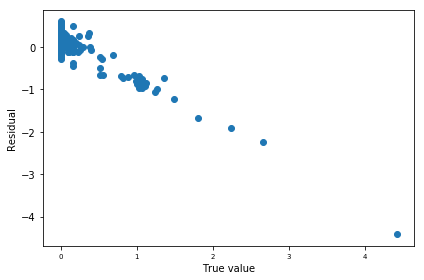

In [368]:
lasso= StatisticalModels.lasso_baseline_model(X_train,y_train, X_test,  y_test)

R squared Score on Train: 0.9985934735057298
R squared Score on Test: 0.9971654545730546
Adjusted R Squared Score on Train: 0.9971604087757187
Adjusted R Squared Score on Test: 1.0054713318706154
Root Mean Squared error on Train: 0.0005581006146664105
Root Mean Squared error on Test: 0.0006152274354072646
Ridge baseline model: Time Taken-  0.016975879669189453


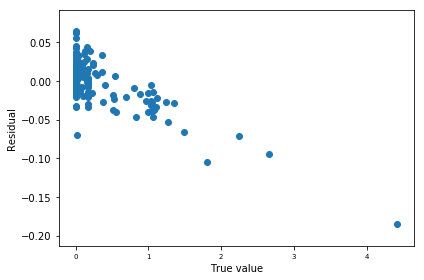

In [370]:
ridge= StatisticalModels.ridge_baseline_model(X_train,y_train, X_test,  y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=0.9999917888437753, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] .............. alpha=0.001, score=0.99999457221019, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=0.9999936605765125, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=0.9999658214622372, total=   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=0.9999932019711825, total=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.1 .......................................................
[CV] .............. alpha=0.1, score=0.9178884751557436, total=   0.0s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.1 .......................................................
[CV] .............. alpha=0.1, score=0.9457221105642936, total=   0.0s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.1 .......................................................
[CV] ............... alpha=0.1, score=0.936605764164044, total=   0.0s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.1 .......................................................
[CV] .............. alpha=0.1, score=0.6582146224288083, total=   0.3s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s


[CV] alpha=0.1 .......................................................
[CV] .............. alpha=0.1, score=0.9320197096665872, total=   0.0s
[CV] alpha=10 ........................................................
[CV] .............. alpha=10, score=-0.5216562992021103, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.1304027827114439, total=   0.0s
[CV] alpha=10 ........................................................
[CV] .............. alpha=10, score=0.03744467435395227, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ............. alpha=10, score=0.028954466198187534, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ............ alpha=10, score=-0.021495379003821036, total=   0.0s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.5s finished


Best Parameters{'alpha': 0.001}
R squared Score on Train: 0.9999930149250204
R squared Score on Test: 0.9999919504300675
Adjusted R Squared Score on Train: 0.9999858980561732
Adjusted R Squared Score on Test: 1.0000155375419628
Root Mean Squared error on Train: 2.7716325682354644e-06
Root Mean Squared error on Test: 1.7471289112685324e-06
Lasso Regression Grid search model: Time Taken-  0.5528256893157959


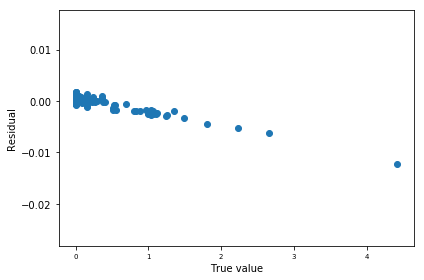

In [373]:
lasso= StatisticalModels.lasso_grid_search(X_train,y_train, X_test,  y_test, parameters = {"alpha": [0.001, 0.1, 10]})

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   18.3s remaining:   36.6s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   18.3s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   18.3s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   18.4s finished


Best Parameters{'alpha_1': 0.1}
R squared Score on Train: 0.957089153371388
R squared Score on Test: 0.9298285506259666
Adjusted R Squared Score on Train: 0.9133686681271418
Adjusted R Squared Score on Test: 1.1354472162335993
Root Mean Squared error on Train: 0.01702674636904813
Root Mean Squared error on Test: 0.015230449449427282
Bayes Ridge Regression Grid search model: Time Taken-  18.98122549057007


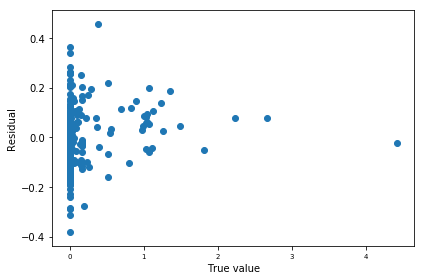

In [371]:
ridge= StatisticalModels.BayesRidge_grid_search(X_train,y_train, X_test,  y_test,parameters = {"alpha_1": [ 0.001, 0.1]})

feature importance-                                        importance
dep_value_growth                     9.999988e-01
days_since_last_purchase_vehicle     3.382957e-07
current_owned_lexus_ind              1.535489e-07
est_current_mileage                  1.516174e-07
active_brand                         1.118895e-07
past_owned_lexus_ind                 1.063187e-07
association_type                     9.219778e-08
max_value_vehicles_per_hh            3.969216e-08
no_ro_visits_0_6mo                   3.877474e-08
total_warranty_pay                   3.228709e-08
current_owned_lexus_sedan_ind        3.183846e-08
no_ro_visits_12_18mo                 1.366782e-08
avg_service_assoc_length             1.249659e-08
length_of_residence                  1.241968e-08
no_ro_visits                         8.473606e-09
current_owned_lexus_new_sedan_ind    5.375467e-09
avg_warrpay_recent                   5.373337e-09
avg_assoc_length                     4.520978e-09
no_ro_visits_36_48mo          

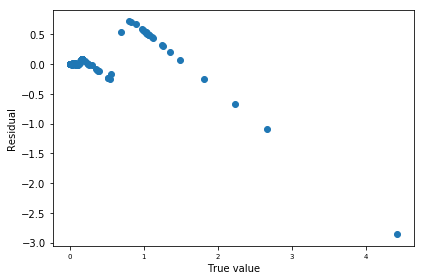

In [366]:
rf= MLModels.mlmodel_randomForest_regressor(X_train,y_train, X_test,  y_test)

feature importance-                                              importance
dep_value_growth                           9.946113e-01
customer_id                                2.568690e-03
avg_warrpay_recent                         1.861088e-03
no_ro_visits                               2.703574e-04
current_owned_lexus_new_luv_ind            2.694309e-04
length_of_residence                        1.517917e-04
i1_education_confidence                    8.320145e-05
max_cust_pay_18_24mo                       6.497412e-05
last_serviced_dealer_no                    4.767659e-05
cruise_enthusiasts_cd                      1.144557e-05
avg_assoc_length                           8.838391e-06
avg_zip3_vehicle_val                       8.243907e-06
total_warranty_pay                         5.959286e-06
first_purchase_vehicle_msrp                5.770873e-06
first_purchase_big_engine_ind              4.151330e-06
no_ro_visits_48_60mo                       3.132050e-06
max_value_vehicles_per_hh   

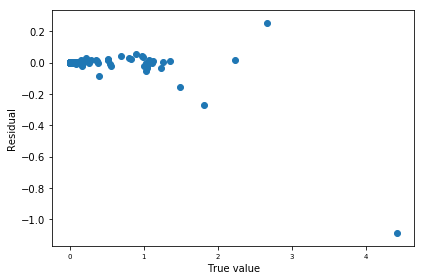

In [379]:
dt= mlmodel_decisionTree_regressor(X_train,y_train, X_test,  y_test)

feature importance-                                            importance
dep_value_growth                             0.910671
avg_custpay_recent_vehicle                   0.016209
creditcard_cd                                0.016030
pma_lexus_dealership_cd                      0.014144
total_warranty_pay                           0.010011
customer_language_english_ind                0.009865
household_id                                 0.006905
owned_vehicle_my_1991_00_ind                 0.004927
purchased_vehicle_cpo_ind                    0.003247
avg_service_assoc_length                     0.002819
length_of_residence                          0.002084
no_repairs_under_warranty_most_recent_veh    0.001309
past_owned_es_ind                            0.000960
purchased_vehicle_lexus_sedan_ind            0.000818
cruise_enthusiasts_cd                        0.000000
photography_cd                               0.000000
home_business_ind                            0.000000
aged_par

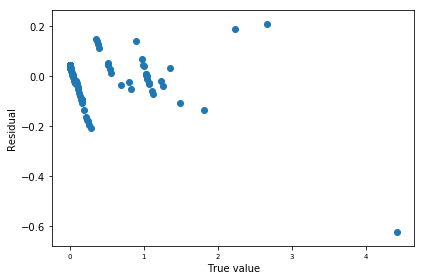

In [381]:
adaboost= MLModels.mlmodel_adaboostTree_regressor(X_train,y_train, X_test,  y_test)

### Finding the p value

In [ ]:
def ols(X,y):
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    return est2

In [60]:
ols(X,y)

                            OLS Regression Results                            
Dep. Variable:       dep_value_growth   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     2374.
Date:                Fri, 23 Nov 2018   Prob (F-statistic):               0.00
Time:                        07:45:23   Log-Likelihood:            -1.4257e+06
No. Observations:             1129455   AIC:                         2.852e+06
Df Residuals:                 1129279   BIC:                         2.854e+06
Df Model:                         175                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] alpha=0.1, fit_intercept=True, normalize=True ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.1, fit_intercept=True, normalize=True, score=0.26793204768213374, total=   3.7s
[CV] alpha=0.1, fit_intercept=True, normalize=True ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=True, score=0.26376156743778967, total=   3.1s
[CV] alpha=0.1, fit_intercept=True, normalize=True ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=True, score=0.2651127779678737, total=   3.1s
[CV] alpha=0.1, fit_intercept=True, normalize=True ...................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=True, score=0.2669258290034128, total=   3.3s
[CV] alpha=0.1, fit_intercept=True, normalize=True ...................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.2s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=True, score=0.2692020377457185, total=   3.5s
[CV] alpha=0.1, fit_intercept=True, normalize=False ..................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.4s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=False, score=0.2708332235025105, total=   2.6s
[CV] alpha=0.1, fit_intercept=True, normalize=False ..................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   23.6s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=False, score=0.2658813656507011, total=   2.4s
[CV] alpha=0.1, fit_intercept=True, normalize=False ..................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   26.7s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=False, score=0.2675668954002851, total=   2.5s
[CV] alpha=0.1, fit_intercept=True, normalize=False ..................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   29.8s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=False, score=0.2695998265663967, total=   3.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False ..................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   33.5s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=False, score=0.2718847790077399, total=   2.5s
[CV] alpha=0.1, fit_intercept=False, normalize=True ..................
[CV]  alpha=0.1, fit_intercept=False, normalize=True, score=0.2708332051030897, total=   2.2s
[CV] alpha=0.1, fit_intercept=False, normalize=True ..................
[CV]  alpha=0.1, fit_intercept=False, normalize=True, score=0.26588137621938734, total=   2.2s
[CV] alpha=0.1, fit_intercept=False, normalize=True ..................
[CV]  alpha=0.1, fit_intercept=False, normalize=True, score=0.26756690897009017, total=   2.6s
[CV] alpha=0.1, fit_intercept=False, normalize=True ..................
[CV]  alpha=0.1, fit_intercept=False, normalize=True, score=0.2695998194649719, total=   2.1s
[CV] alpha=0.1, fit_intercept=False, normalize=True ..................
[CV]  alpha=0.1, fit_intercept=False, normalize=True, score=0.2718847818654645, total=   2.1s
[CV] alpha=0.1, fit_intercept=False, normalize=False .................
[CV]  al

[CV]  alpha=10.0, fit_intercept=False, normalize=False, score=0.2718851305931219, total=   2.1s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.3min finished


('Ridge Grid search : \nTime Taken- ',
 '202.38733887672424',
 ' \nScore on Traing Set',
 '0.2695006193635028',
 ' \nScore on Test Set ',
 '0.26705603170405456',
 ' \nAdjusted R Square Score on Training Set ',
 '0.2693039475813409',
 ' \nAdjusted R Square Score on Test Set',
 '0.26646372226080406',
 '\n Best Parameters',
 "{'alpha': 10.0, 'fit_intercept': True, 'normalize': False}")

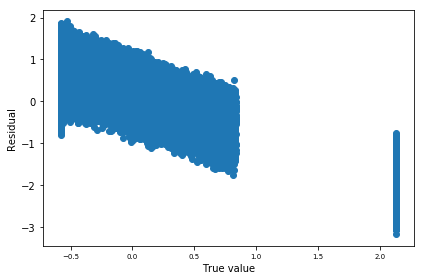

In [73]:
StatisticalModels.ridge_grid_search(X_train,y_train, X_test,  y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] alpha=0.1, fit_intercept=True, normalize=True ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.1, fit_intercept=True, normalize=True, score=-6.228370930116967e-08, total=   4.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=True, score=-1.0066313211876121e-06, total=   3.8s
[CV] alpha=0.1, fit_intercept=True, normalize=True ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=True, score=-3.231610774201421e-05, total=   3.7s
[CV] alpha=0.1, fit_intercept=True, normalize=True ...................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.5s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=True, score=-3.5646876700656804e-05, total=   3.7s
[CV] alpha=0.1, fit_intercept=True, normalize=True ...................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.8s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=True, score=-1.8268019896794385e-07, total=   4.2s
[CV] alpha=0.1, fit_intercept=True, normalize=False ..................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.6s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=False, score=0.1939375467805713, total=   3.4s
[CV] alpha=0.1, fit_intercept=True, normalize=False ..................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   26.7s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=False, score=0.19274767410176208, total=   3.5s
[CV] alpha=0.1, fit_intercept=True, normalize=False ..................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   30.8s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=False, score=0.19318766578361424, total=   3.8s
[CV] alpha=0.1, fit_intercept=True, normalize=False ..................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   35.3s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=False, score=0.1930128015115351, total=   3.7s
[CV] alpha=0.1, fit_intercept=True, normalize=False ..................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   39.7s remaining:    0.0s


[CV]  alpha=0.1, fit_intercept=True, normalize=False, score=0.19501025057596857, total=   3.7s
[CV] alpha=0.1, fit_intercept=False, normalize=True ..................
[CV]  alpha=0.1, fit_intercept=False, normalize=True, score=0.17557799171555255, total=   3.5s
[CV] alpha=0.1, fit_intercept=False, normalize=True ..................
[CV]  alpha=0.1, fit_intercept=False, normalize=True, score=0.17556997096960336, total=   3.7s
[CV] alpha=0.1, fit_intercept=False, normalize=True ..................
[CV]  alpha=0.1, fit_intercept=False, normalize=True, score=0.17541519892867774, total=   3.4s
[CV] alpha=0.1, fit_intercept=False, normalize=True ..................
[CV]  alpha=0.1, fit_intercept=False, normalize=True, score=0.17535947981509992, total=   3.3s
[CV] alpha=0.1, fit_intercept=False, normalize=True ..................
[CV]  alpha=0.1, fit_intercept=False, normalize=True, score=0.17616452903906288, total=   3.7s
[CV] alpha=0.1, fit_intercept=False, normalize=False .................
[CV]

[CV]  alpha=10.0, fit_intercept=False, normalize=False, score=-3.50643329516398e-05, total=   3.0s
[CV] alpha=10.0, fit_intercept=False, normalize=False ................
[CV]  alpha=10.0, fit_intercept=False, normalize=False, score=-2.2194391284813264e-06, total=   2.6s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.0min finished


('Lasso Grid search : \nTime Taken- ',
 '245.42332530021667',
 ' \nScore on Traing Set',
 '0.19360334970033044',
 ' \nScore on Test Set ',
 '0.1933454410680876',
 ' \nAdjusted R Square Score on Training Set ',
 '0.19338624415507244',
 ' \nAdjusted R Square Score on Test Set',
 '0.192693564344404',
 '\n Best Parameters',
 "{'alpha': 0.1, 'fit_intercept': True, 'normalize': False}")

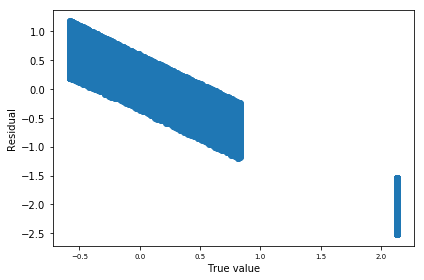

In [74]:
StatisticalModels.lasso_grid_search(X_train,y_train, X_test,  y_test)

('XGB regressor:  Time Taken- ',
 '415.36496567726135',
 '  Score on Traing Set',
 '0.30934529556295043',
 '  Score on Test Set ',
 '0.3067777269606732',
 '  Adjusted R Square Score on Training Set ',
 '0.3091593511320849',
 '  Adjusted R Square Score on Test Set',
 '0.3062175175635655')

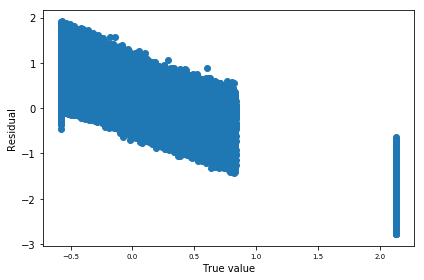

In [75]:
MLModels.mlmodel_xgb_regressor(X_train,y_train, X_test,  y_test)

In [8]:
!conda list

# packages in environment at /root/anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0            py36he11e457_0  
absl-py                   0.5.0                      py_0    conda-forge
alabaster                 0.7.10           py36h306e16b_0  
alembic                   0.9.9                      py_0    conda-forge
anaconda                  custom           py36hbbc8b67_0  
anaconda-client           1.6.14                   py36_0  
anaconda-navigator        1.8.7                    py36_0  
anaconda-project          0.8.2            py36h44fb852_0  
arrow-cpp                 0.10.0           py36h70250a7_0    conda-forge
asn1crypto                0.24.0                   py36_0  
astor                     0.7.1                      py_0    conda-forge
astroid                   1.6.3                    py36_0  
astropy                   3.0.2            py36h3010b51_1  
async_generator           1.10                       

In [1]:
!jupyter nbconvert --to script Model1_lexus_c360_customeradt_lexussegmentation_2012_09_30.ipynb

[NbConvertApp] Converting notebook Model1_lexus_c360_customeradt_lexussegmentation_2012_09_30.ipynb to script
[NbConvertApp] Writing 42294 bytes to Model1_lexus_c360_customeradt_lexussegmentation_2012_09_30.py


R squared Score on Train: 0.0
R squared Score on Test: -1.2216851308366472e-07
Adjusted R Squared Score on Train: -0.0002515123211517256
Adjusted R Squared Score on Test: -0.0007550398577631512
Root Mean Squared error on Train: 0.21419339519374828
Root Mean Squared error on Test: 0.18193201519910282
Lasso baseline model: Time Taken-  3.0509016513824463


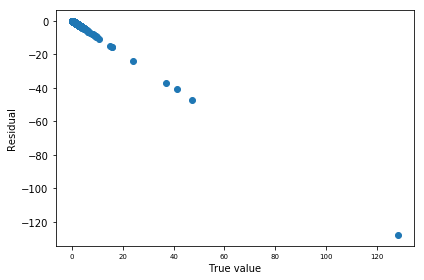

In [325]:
lasso= StatisticalModels.lasso_baseline_model(X_train, y_train, X_test, y_test)

R squared Score on Train: 0.10287370298715648
R squared Score on Test: 0.11925863908376977
Adjusted R Squared Score on Train: 0.10264806466982856
Adjusted R Squared Score on Test: 0.11859375193198829
Root Mean Squared error on Train: 0.19215852747477596
Root Mean Squared error on Test: 0.1602350310850146
Linear Regression baseline model: Time Taken-  5.0344767570495605


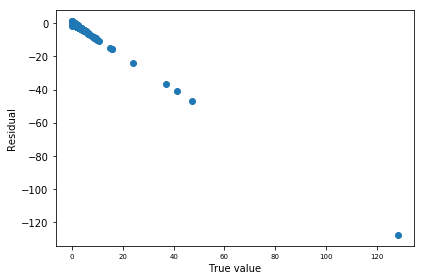

In [434]:
ridge= StatisticalModels.linear_baseline_model(X_train, y_train, X_test, y_test)


 mu = 0.16 and sigma = 0.46



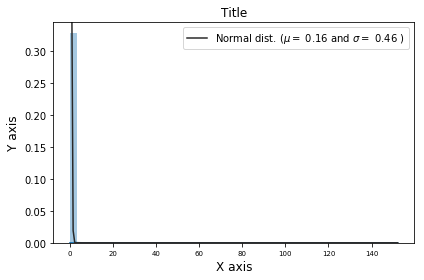

In [482]:
plot_histogram(y_train)

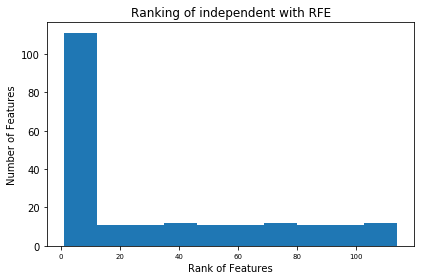

In [491]:
plot_feature_ranking(X_train, y_train)